## Introduction
The purpose of this notebook is to quickly train a image classifier that is able to distinguish between images of cats and dogs and achieve some acceptable degree of performance (a binary classification problem). Accuracy will be used to evaluate the performance and we'll train a simple CNN to classify the images.

In order to make this notebook neat, some helper functions are defined in the [utils.py](utils.py), feel free to check it out when you want to dig deeper.

## Libraries

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
from utils import *
from settings import TRAIN_DIR, TEST_DIR, TRAIN_X_MEAN_NPY, TRAIN_X_STD_NPY, LOG_DIR, SAVE_PATH
%matplotlib inline


/Users/leemeng/anaconda3/envs/cat/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Dataset preparation
The image data we're going to use is [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset available on [Kaggle](https://www.kaggle.com/) which contain 25,000 images of dogs and cats. You may need a Kaggle account to download the dataset on your local machine. The training set and test set  will be stored under ```datasets/train``` and ```datasets/test1``` subdirectories respectively. To make the whole training process reproducable, we first set random seeds of TensorFlow and Numpy.

In [5]:
tf.set_random_seed(94)
np.random.seed(87)

In [6]:
print("Number of training images: {}".format(len(glob.glob(os.path.join(TRAIN_DIR, '*.jpg')))))
print("Number of test images: {}".format(len(glob.glob(os.path.join(TEST_DIR, '*.jpg')))))

Number of training images: 25000
Number of test images: 12500


### Load the dataset and resize the images
The dataset will include two parts:
- X: the actual images transformed to ndarray with shape of ```(#images, height, width, #channels)```
- y: corresponding labels, where ```label = 0``` for dog images and ```label = 1``` for cat images.

There are 25,000 images in total available for training. We will shuffle the whole dataset, use all of them, 20,000 of which training and 5,000 validation, and resize the images' height and width to [64, 64] to make our model simpler.

In [7]:
image_size = 64
dataset_size = len(glob.glob(os.path.join(TRAIN_DIR, '*.jpg')))

We will save the resized images and labels as `features.npy` and `targets.npy` in the directory `datasets/train/` when the images are loaded first time. It will become faster when you reload the dataset again.

In [8]:
%%time
X, y = load_image_dataset(size=(image_size, image_size))
perm = np.random.permutation(dataset_size)
X, y = X[perm], y[perm]  # X is only shuffled along it's first index.
print(X.shape, y.shape)

(25000, 64, 64, 3) (25000, 1)
CPU times: user 84.3 ms, sys: 341 ms, total: 426 ms
Wall time: 523 ms


### Inspect images in the dataset

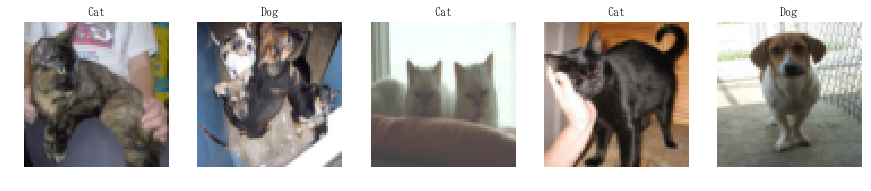

In [9]:
num_samples = 5
show_images_horizontally(X[:num_samples], y[:num_samples], figsize=(15, 10),
                         lookup_label={0: 'Dog', 1: 'Cat'})

### Build training / validation set
It's a good practice to make a subset of dataset as validation set and tuning our models before actually test their performance on the test set. The dataset has already been shuffled, so we only have to seperate it into training set / validation set in the ratio of (0.9, 0.1).

In [10]:
train_set_ratio = 0.9
idx = int(dataset_size * train_set_ratio)
valid_set_size = X.shape[0] - idx
train_X, train_y, valid_X, valid_y = X[:idx], y[:idx], X[idx:], y[idx:]

Training set: (22500, 64, 64, 3), (22500, 1)
Validation set: (2500, 64, 64, 3), (2500, 1)
Some images in validation set:


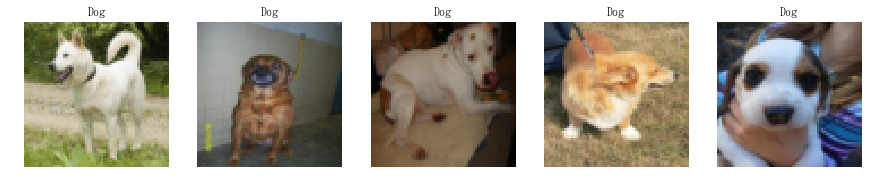

In [11]:
print('Training set: {}, {}'.format(train_X.shape, train_y.shape))
print('Validation set: {}, {}'.format(valid_X.shape, valid_y.shape))
print('Some images in validation set:')
show_images_horizontally(valid_X[:num_samples], valid_y[:num_samples], figsize=(15, 10),
                         lookup_label={0: 'Dog', 1: 'Cat'})

### Normalization
To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to **center and standardize** your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. Note that validation data are only for validation use, so we can pretend that we have "seen" the validation data. Not letting validation data polluting the training process (also known as **data leak** problem), we use only training data's mean and std to normalize the data.

-0.0133896 1.00569
CPU times: user 2.09 s, sys: 1.85 s, total: 3.95 s
Wall time: 5.11 s


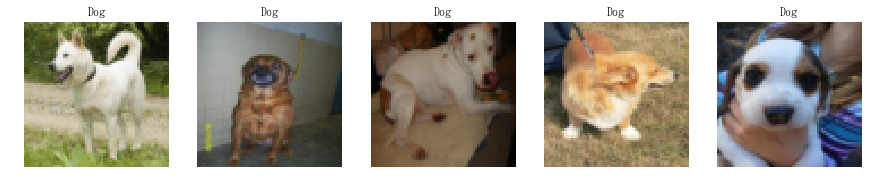

In [12]:
%%time
train_X, valid_X = train_X.astype(np.float32), valid_X.astype(np.float32)
train_X_mean, train_X_std = train_X.mean(), train_X.std()
np.save(TRAIN_X_MEAN_NPY, train_X_mean)
np.save(TRAIN_X_STD_NPY, train_X_std)
train_X = (train_X - train_X_mean) / train_X_std
valid_X = (valid_X - train_X_mean) / train_X_std  # Use train_X's mean and std to normalize valid_X.
show_images_horizontally((valid_X[:num_samples] * train_X_std + train_X_mean).astype(np.uint8), valid_y[:num_samples], figsize=(15, 10),
                         lookup_label={0: 'Dog', 1: 'Cat'})
print(valid_X.mean(), valid_X.std())

We can see that the validation data's mean is close to 0 and std close to 1, which is good.


### Class distribution in dataset
Make sure the distribution of training/validation set are similar and there is no serious unbalanced class problem. In this dataset, there are only two classes: cats and dogs, so it will be prefect that the dataset consist of about 50% of dogs and cats, respectively.

In [13]:
train_cat, valid_cat = train_y == 1, valid_y == 1
print('{:.1f}% images in training set are cats'.format(len(train_y[train_cat]) / len(train_y) * 100))
print('{:.1f}% images in validation set are cats'.format(len(valid_y[valid_cat]) / len(valid_y) * 100))

49.9% images in training set are cats
50.6% images in validation set are cats


Seems that we're good to go.

## Build the classifier
For the binary classification we're facing (for any image, whether it's a cat image or dog image), we will use a simple convoluational neural network with two convolational layers followed by a fully connected layer. In terms of regularization, we will use dropout between conv and fully-connected layer.

### Hyper parameters

In [14]:
batch_size = 64
patch_size = 5
input_depth = 3
output_depth = 16
num_hidden = 16
keep_prob = 0.5

### Evaluation metric

In [15]:
def accuracy(predictions, labels):
    return (100.0 * np.sum((predictions > 0.5).astype(float) == labels)\
            / predictions.shape[0])

### Define layer templates for model
We will define all related stuffs (weights, bias, relu) in the `tf.name_scope`and use `tf.summary` op to save graph data for both convoluational layer and fully-connected layer respectively. This will enable tensorboard to visualize our model later.

In [13]:
# convolutional layer
def conv_layer(input, patch_size, input_depth, output_depth, name="conv", params=None):
    with tf.name_scope(name):
        w_name = '.'.join((name, 'w'))
        b_name = '.'.join((name, 'b'))
        
        if params and params[w_name]:
            w = params[w_name]
            b = params[b_name]
        else:
            w = tf.Variable(
                tf.truncated_normal([patch_size, patch_size, input_depth, output_depth], stddev=0.1), name="Weights")
            b = tf.Variable(tf.constant(0.1, shape=[output_depth]), name="Biases")
            params[w_name] = w
            params[b_name] = b
        
#         conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
        conv = tf.nn.conv2d(input, w, strides=[1, 2, 2, 1], padding="SAME")
        act = tf.nn.relu(conv + b)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
#         pool = tf.nn.max_pool(act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")


        return act

# fully-connected layer
def fc_layer(input, size_in, size_out, name="fc", params=None):
    with tf.name_scope(name):
        w_name = '.'.join((name, 'w'))
        b_name = '.'.join((name, 'b'))
        
        if params and params[w_name]:
            w = params[w_name]
            b = params[b_name]
        else:
            w = tf.Variable(tf.truncated_normal([size_in, size_out], stddev=0.1), name="Weights")
            b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="Biases")
            params[w_name] = w
            params[b_name] = b
        
        act = tf.matmul(input, w) + b
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return act

### Computation graph
After instruct our model how to do forward prop, TensorFlow will do the back prop for us automatically.
Some tips here:
- make sure to name every tensor for easier reference later
- create tensors designed for single image prediction: ```tf_new_X``` and ```tf_new_y```
- set keep_prob of dropout to 1 when making prediction

In [14]:
graph = tf.Graph()

with graph.as_default():
    # input of every mini-batch training data
    tf_train_X = tf.placeholder(tf.float32, name='tf_train_X',
        shape=(batch_size, image_size, image_size, input_depth))
    tf_train_y = tf.placeholder(tf.float32, name='tf_train_y', 
        shape=(batch_size, 1))
    
    # show some images in tensorboard
    tf.summary.image('training_images', tf_train_X, 16)
    
    # input for every single realtime prediction
    tf_new_X = tf.placeholder(tf.float32, name='tf_new_X',
        shape=(1, image_size, image_size, input_depth))
    tf_new_y = tf.placeholder(tf.float32, name='tf_new_y',
        shape=[1, 1])
    
    # use entire validation set to evaluate model
    tf_valid_X = tf.constant(valid_X.astype('float32'),
        name='tf_valid_X')
    tf_valid_y = tf.constant(valid_y.astype('float32'), name='tf_valid_y')
    
    # turn off dropout regularization when predict and allow
    # adjustment when training
    tf_keep_prob_train = tf.placeholder_with_default(1.0, 
        name='tf_keep_prob_train', shape=())
    tf_keep_prob_valid = tf.constant(1.0, name='tf_keep_prob_valid',
        shape=())

    params = {
        'conv1.w': None, 'conv1.b': None,
        'conv2.w': None, 'conv2.b': None,
        'fc1.w': None, 'fc1.b': None,
        'fc2.w': None, 'fc2.b': None
    }
    
    
    # create the network
    def model(data, keep_prob, params):
        conv1 = conv_layer(
            data, patch_size, input_depth, output_depth, 'conv1', params)
        conv2 = conv_layer(
            conv1, patch_size, output_depth, output_depth, 'conv2', params)
        shape = conv2.get_shape().as_list()
        flattened = tf.reshape(conv2,
            [-1, shape[1] * shape[2] * shape[3]])
        
        dropout = tf.nn.dropout(flattened, keep_prob)
        fc1 = fc_layer(dropout,
            image_size // 4 * image_size // 4 * output_depth,
            num_hidden, 'fc1', params)
        with tf.name_scope('relu'):
            hidden_act = tf.nn.relu(fc1)
        
        return fc_layer(hidden_act, num_hidden, 1, 'fc2', params)
    
    
    # Training computation.
    logits = model(tf_train_X, tf_keep_prob_train, params)
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf_train_y, logits=logits), name='loss')
        tf.summary.scalar("cross_entropy", loss)

    # Optimizer.
    with tf.name_scope('train'):
        optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    # Predictions for the training, validation set and new image
    tf_train_y_pred = tf.nn.sigmoid(logits, name='tf_train_y_pred')
    tf_valid_y_pred = tf.nn.sigmoid(
        model(tf_valid_X, tf_keep_prob_valid, params), name='tf_valid_y_pred')
    tf_new_y_pred = tf.nn.sigmoid(
        model(tf_new_X, tf_keep_prob_valid, params), name='tf_new_y_pred')
    
    
    with tf.name_scope("evaluation"):
        def acc(pred, label):
            sh = label.shape
            return tf.reduce_sum(tf.cast(tf.equal(tf.where(
                pred > 0.5, tf.ones(sh), tf.zeros(sh)), label), tf.int32)) / sh[0]
        
        train_acc = acc(tf_train_y_pred, tf_train_y)
        valid_acc = acc(tf_valid_y_pred, tf_valid_y)
        tf.summary.scalar("batch_accuracy", train_acc)
        tf.summary.scalar("valid_accuracy", valid_acc)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

### Train and serialize model
We will use mini-batch GD to train our model. After finish training, save the trained model for later usage.

Tips:
- set keep_prob of dropout regularization to 0.5 when training

In [15]:
%%time
num_steps = 140625  # 400 epochs
step_interval = 500

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
#     tf.local_variables_initializer().run() # for init 'total' in tf.metrics.accuracy
    
    # write to log for tensorboard
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter(LOG_DIR)
    writer.add_graph(sess.graph)
    
    
    for step in range(num_steps):
        # get new mini-batch for training
        offset = (step * batch_size) % (train_y.shape[0] - batch_size)
        batch_X = train_X[offset:(offset + batch_size), :, :, :]
        batch_y = train_y[offset:(offset + batch_size), :]
        
        # enable dropout regularization when training
        feed_dict = {
            tf_train_X: batch_X,
            tf_train_y: batch_y,
            tf_keep_prob_train: 0.5,
            tf_new_X: batch_X[:1]
        }
        _, l, batch_y_pred = sess.run(
            [optimizer, loss, tf_train_y_pred], feed_dict=feed_dict)
        

        # write summary
        if (step % 100 == 0):
            s = sess.run(merged_summary, feed_dict=feed_dict)
            writer.add_summary(s, step)
        
        # output loss and accuracy while training
        if (step % step_interval == 0):
            print('Minibatch loss at step {}: {:.3f}, '.format(step, l) +
                  'batch acc: {:.1f}%, Valid acc: {:.1f}%.'\
                  .format(accuracy(batch_y_pred, batch_y),
                          accuracy(tf_valid_y_pred.eval(), valid_y)))
            
    # final prediction for validation set
    vaild_y_pred_before_restore = tf_valid_y_pred.eval()
    
    
    # Save the variables to disk.
    save_path = saver.save(sess, SAVE_PATH)
    print("Model saved in file: %s" % SAVE_PATH)
    
    writer.flush()
    writer.close()

Minibatch loss at step 0: 0.780, batch acc: 50.0%, Valid acc: 51.9%.
Minibatch loss at step 500: 0.707, batch acc: 59.4%, Valid acc: 62.2%.
Minibatch loss at step 1000: 0.576, batch acc: 75.0%, Valid acc: 69.0%.
Minibatch loss at step 1500: 0.582, batch acc: 71.9%, Valid acc: 71.1%.
Minibatch loss at step 2000: 0.649, batch acc: 57.8%, Valid acc: 71.9%.
Minibatch loss at step 2500: 0.594, batch acc: 70.3%, Valid acc: 73.3%.
Minibatch loss at step 3000: 0.519, batch acc: 73.4%, Valid acc: 73.1%.
Minibatch loss at step 3500: 0.553, batch acc: 60.9%, Valid acc: 72.8%.
Minibatch loss at step 4000: 0.572, batch acc: 67.2%, Valid acc: 75.0%.
Minibatch loss at step 4500: 0.511, batch acc: 76.6%, Valid acc: 75.0%.
Minibatch loss at step 5000: 0.477, batch acc: 78.1%, Valid acc: 76.1%.
Minibatch loss at step 5500: 0.525, batch acc: 78.1%, Valid acc: 75.9%.
Minibatch loss at step 6000: 0.471, batch acc: 76.6%, Valid acc: 76.7%.
Minibatch loss at step 6500: 0.435, batch acc: 76.6%, Valid acc: 75.

Minibatch loss at step 56500: 0.250, batch acc: 87.5%, Valid acc: 80.7%.
Minibatch loss at step 57000: 0.242, batch acc: 89.1%, Valid acc: 80.2%.
Minibatch loss at step 57500: 0.244, batch acc: 87.5%, Valid acc: 79.7%.
Minibatch loss at step 58000: 0.124, batch acc: 98.4%, Valid acc: 79.8%.
Minibatch loss at step 58500: 0.135, batch acc: 95.3%, Valid acc: 81.2%.
Minibatch loss at step 59000: 0.192, batch acc: 95.3%, Valid acc: 81.2%.
Minibatch loss at step 59500: 0.234, batch acc: 89.1%, Valid acc: 81.1%.
Minibatch loss at step 60000: 0.538, batch acc: 82.8%, Valid acc: 80.5%.
Minibatch loss at step 60500: 0.214, batch acc: 93.8%, Valid acc: 80.0%.
Minibatch loss at step 61000: 0.117, batch acc: 95.3%, Valid acc: 80.4%.
Minibatch loss at step 61500: 0.209, batch acc: 92.2%, Valid acc: 80.2%.
Minibatch loss at step 62000: 0.184, batch acc: 92.2%, Valid acc: 81.6%.
Minibatch loss at step 62500: 0.206, batch acc: 92.2%, Valid acc: 80.5%.
Minibatch loss at step 63000: 0.173, batch acc: 90.

Minibatch loss at step 112500: 0.096, batch acc: 96.9%, Valid acc: 80.1%.
Minibatch loss at step 113000: 0.136, batch acc: 92.2%, Valid acc: 80.3%.
Minibatch loss at step 113500: 0.103, batch acc: 96.9%, Valid acc: 80.4%.
Minibatch loss at step 114000: 0.084, batch acc: 96.9%, Valid acc: 81.0%.
Minibatch loss at step 114500: 0.084, batch acc: 98.4%, Valid acc: 80.2%.
Minibatch loss at step 115000: 0.082, batch acc: 96.9%, Valid acc: 80.1%.
Minibatch loss at step 115500: 0.130, batch acc: 98.4%, Valid acc: 80.4%.
Minibatch loss at step 116000: 0.122, batch acc: 95.3%, Valid acc: 80.0%.
Minibatch loss at step 116500: 0.216, batch acc: 92.2%, Valid acc: 80.6%.
Minibatch loss at step 117000: 0.167, batch acc: 92.2%, Valid acc: 80.7%.
Minibatch loss at step 117500: 0.158, batch acc: 92.2%, Valid acc: 80.5%.
Minibatch loss at step 118000: 0.055, batch acc: 96.9%, Valid acc: 80.2%.
Minibatch loss at step 118500: 0.126, batch acc: 95.3%, Valid acc: 81.0%.
Minibatch loss at step 119000: 0.059, 

Although the performance can be further improved, as our goal is to train a simple model and deploy it, we will just leave it here and take a look where did the model make the mistake on validation set.


## Show some mis-classified images

Get indices of mis-classified images in validation set

In [16]:
mislabeled_indices = []
for idx, (i, j) in enumerate(zip(vaild_y_pred_before_restore.reshape(-1, 1), valid_y.reshape(-1, 1))):
    prob, label = i[0], j[0]
    label_pred = 1 if prob > 0.5 else 0
    if label_pred != label: mislabeled_indices.append(idx)
print('{}% of images are mis-classified in validation set.'\
      .format(len(mislabeled_indices) / valid_y.shape[0] * 100))

20.24% of images are mis-classified in validation set.


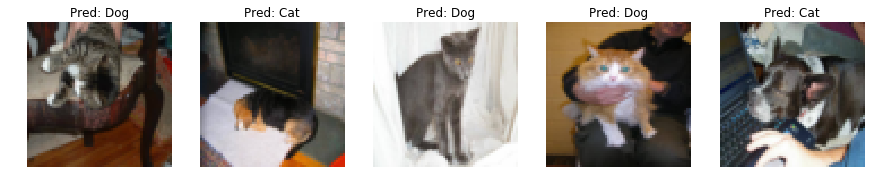

In [17]:
samples = np.random.choice(mislabeled_indices, 5)
show_images_horizontally((valid_X[samples] * train_X_std + train_X_mean).astype(np.uint8), valid_y[samples], figsize=(15, 10),
                         lookup_label={0: 'Pred: Cat', 1: 'Pred: Dog'})


## Real time prediction simulation
Upon now, we already trained a model that is ready to be deploy! Let's load the model we saved earlier and see whether we can generate the same prediction result on validation set using the loaded model.

If there is any error in this part, try to restart kernel and run all the code again.


In [2]:
meta_path = 'models/model.ckpt.meta'


### Load the model and make prediction on validation set

In [16]:
# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.

with tf.Session() as sess:
    
    # Restore variables from disk.
    new_saver = tf.train.import_meta_graph(meta_path)
    new_saver.restore(sess, SAVE_PATH)
    print("Model restored.")
    
    #Now, access the op that you want to run. 
    graph = tf.get_default_graph()
    tf_new_X = graph.get_tensor_by_name("tf_new_X:0")
    tf_new_y = graph.get_tensor_by_name("tf_new_y:0")
    tf_new_y_pred = graph.get_tensor_by_name("tf_new_y_pred:0")

    feed_dict = {
        tf_new_X: valid_X[:1],
        tf_new_y: valid_y[:1]
    }

    new_y_pred = sess.run(
            [tf_new_y_pred], feed_dict=feed_dict)
    
    tf_valid_y_pred = graph.get_tensor_by_name("tf_valid_y_pred:0")

    vaild_y_pred_after_restore = tf_valid_y_pred.eval()


INFO:tensorflow:Restoring parameters from /Users/leemeng/Documents/Code/cat-recognition-app/models/model.ckpt
Model restored.


### Sanity check 
Compare prediction result on validation before/after model restoration to make sure we got the right model.

In [17]:
if np.all(vaild_y_pred_before_restore==vaild_y_pred_after_restore):
    print("Loaded model's prediction on validation is exactly the same as expected.")
else:
    print("Loaded model's prediction on validation is different; something is wrong.")


NameError: name 'vaild_y_pred_before_restore' is not defined

## Save Model as a Frozen Graph
TensorFlow provides an API to convert variables in graph into constants and remove unnecessary nodes such as the optimizer, only nodes needed for prediction remaining. Check out `freeze_graph` in `utils.py` to see how. Here, we demonstrate how to use `freeze_graph` to freeze the trained model.

In [21]:
from settings import META_PATH, PB_PATH
freeze_graph(PB_PATH, 'tf_new_y_pred', meta_path=META_PATH, ckpt_path=SAVE_PATH)

INFO:tensorflow:Restoring parameters from C:\Users\mnicnc404\cat-recognition-app\models\model.ckpt
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.


To use the frozen graph:

In [26]:
tf.reset_default_graph()
with tf.gfile.GFile(PB_PATH, 'rb') as f:
    gd = tf.GraphDef()
    gd.ParseFromString(f.read())
tf.import_graph_def(gd, name='')
with tf.Session() as sess:
    print('Prediction: ', sess.run('tf_new_y_pred:0', {'tf_new_X:0': valid_X[0:1]}))
print('Truth: ', valid_y[0:1])

Prediction:  [[  5.04415630e-06]]
Truth:  [[0]]


## Summary
In next step, we will deploy this model and try to build a ML application.